In [38]:
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from joblib                import dump
from sklearn.impute        import SimpleImputer
from sklearn.metrics       import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LogisticRegressionCV

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [55]:
disease_codes = {'diabetes': 'HC221','renal_failure': 'HC294','gout': 'HC328','myocardial_infarction': 'HC326',
                 'asthma' : 'HC382','gall_stones': 'HC188','ulcerative_colitis': 'HC201','peripheral_vascular_disease': 'HC385',
                 'atrial_flutter': 'HC440','osteoarthritis': 'HC376','arthritis_(nos)': 'HC78','TTE_cystitis': 'HC1313',
                 'TTE_chronic_renal_failure': 'HC1302','TTE_psoriasis': 'HC1159','TTE_cellulitis': 'HC1139','TTE_cholelithiasis': 'HC1125',
                 'glaucoma': 'HC276','Blood_clot_or_DVT': 'BIN_FC11006152','skin_cancer': 'cancer1003'}

## Load data

In [23]:
%%time

meta  = pd.read_csv('data/meta.csv')
prs   = pd.read_csv('data/prs.csv')
pheno = pd.read_csv('data/pheno.csv')

CPU times: user 1min 1s, sys: 8.09 s, total: 1min 9s
Wall time: 1min 9s


## Only have one column to split the data

In [24]:
prs['final_split']   = prs.split_nonWB.fillna(prs.split)
pheno['final_split'] = pheno.split_nonWB.fillna(prs.split)
meta['final_split']  = pheno.split_nonWB.fillna(prs.split)

In [25]:
global_pc_cols = [f"Global_PC{i}" for i in range(1, 41)]
pc_cols = [f"PC{i}" for i in range(1, 41)]
drop_cols = global_pc_cols + pc_cols + ['split','IID','age', 'age0', 'age1', 'age2', 'age3', 'sex', 'BMI', 'N_CNV', 'LEN_CNV', 'Array']

In [26]:
meta = meta.drop(drop_cols, axis=1)

In [27]:
diseases = list(disease_codes.values())

# Fit WB models

In [28]:
def cv_train_model(X_train, y_train):
    
    cv = LogisticRegressionCV(
        Cs=50, 
        penalty='l1', 
        cv=3,
        class_weight='balanced', 
        solver='saga', 
        verbose=0,
        max_iter=500
    )
    
    cv.fit(X_train, y_train)
    return cv

## Fit models

In [29]:
def prepare_data(populations, disease, pheno, meta):
    np.random.seed(123)

    y = pheno[pheno['population'].isin(populations)]
    X = meta[meta['population'].isin(populations)]

    # Ensure y only contains 1 or 2, and filter X accordingly
    valid_y_indices = y[disease].isin([1, 2])
    y = y[valid_y_indices]
    X = X[valid_y_indices]

    X['population'] = np.where(X['population'] == "white_british", 0, np.where(X['population'] == "s_asian", 1, np.nan))

    y_train_val = y[y['final_split'].isin(['train', 'val'])][disease]
    y_test = y[(y['final_split'] == 'test') & (y['population'] == 's_asian')][disease]

    X_train_val = X[X['final_split'].isin(['train', 'val'])]
    X_test = X[(X['final_split'] == 'test') & (X['population'] == 1)]

    X_train_val.drop(columns=['final_split'], inplace=True)
    X_test.drop(columns=['final_split'], inplace=True)

    # Impute missing numeric values in training and testing sets
    num_cols = X_train_val.select_dtypes(include='number').columns
    X_train_val[num_cols] = X_train_val[num_cols].apply(lambda x: x.fillna(x.mean()), axis=0)
    X_test[num_cols] = X_test[num_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

    y_train_val = y_train_val - 1
    y_test      = y_test - 1
    
    # Include all South Asian cases in training set
    sa_indices = X_train_val[X_train_val['population'] == 1].index
    
    # Count of South Asian cases without disease
    num_sa_without_disease = ((X_train_val['population'] == 1) & (y_train_val == 0)).sum()
    
    # Sample up to an equal number of WB cases with and without disease
    wb_indices_with_disease    = X_train_val[(X_train_val['population'] == 0) & (y_train_val == 1)].index
    wb_indices_without_disease = X_train_val[(X_train_val['population'] == 0) & (y_train_val == 0)].index


    num_to_sample_wb_with    = min(num_sa_without_disease, len(wb_indices_with_disease))
    num_to_sample_wb_without = min(num_sa_without_disease, len(wb_indices_without_disease))

    sampled_wb_indices_with_disease = np.random.choice(wb_indices_with_disease, num_to_sample_wb_with, replace=False)
    sampled_wb_indices_without_disease = np.random.choice(wb_indices_without_disease, num_to_sample_wb_without, replace=False)

    final_indices_train_val = np.concatenate([sa_indices, sampled_wb_indices_with_disease, sampled_wb_indices_without_disease])

    X_train = X_train_val.loc[final_indices_train_val]
    y_train = y_train_val.loc[final_indices_train_val]

    scaler              = StandardScaler()
    X_train_val_columns = X_train_val.columns
    X_test_columns      = X_test.columns

    X_train_val = scaler.fit_transform(X_train_val)  
    X_test      = scaler.transform(X_test)  
    
    X_train_val = pd.DataFrame(X_train_val, columns=X_train_val_columns)
    X_test      = pd.DataFrame(X_test,      columns=X_test_columns)
    
    # Print out statistics
    combined_df = pd.concat([X_train, pd.DataFrame({'y_train': y_train})], axis=1)
    combined_df['population'] = combined_df['population'].map({0: 'WB', 1: 'SA'})
    combined_df['combined'] = combined_df['population'].astype(str) + '-' + combined_df['y_train'].astype(str)
    value_counts = combined_df['combined'].value_counts()
    print(value_counts)

    return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}


In [30]:
def fit_models(model_dir_path, disease, prepared_data, update_models):
    print(f'Disease: {disease}')

    model_path = os.path.join(model_dir_path, f'{disease}.joblib')

    if os.path.exists(model_path) and not update_models:
        print(f'Already fitted model for disease {disease}\n')
        cv_fit = joblib.load(model_path)
        return cv_fit

    X_train = prepared_data['X_train']
    y_train = prepared_data['y_train']

    if np.any(np.isnan(y_train)) or np.any(np.isnan(X_train)):
        raise ValueError("NA values found in Y or X.")

    print('Fitting model')
    cv_fit = cv_train_model(X_train, y_train)
    print('Finished fitting model\n')
    
    joblib.dump(cv_fit, model_path)
    return cv_fit

# Fit models

In [31]:
populations    = ['white_british', 's_asian']
model_dir_path = 'models/log_reg/WB_SA_only_metabolomics/'

In [32]:
aucs = []

for disease in disease_codes.values():
    prepared_data = prepare_data(populations, disease, pheno, meta)
    
    start_time = time.time()
    cv_fit = fit_models(model_dir_path, disease, prepared_data, update_models=False)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time for fitting model: {elapsed_time} seconds")

    X_test = prepared_data['X_test']
    y_test = prepared_data['y_test']
    
    predictions = cv_fit.predict_proba(X_test)
    
    positive_class_probabilities = predictions[:, 1]

    # Compute ROC AUC score
    roc_auc = roc_auc_score(y_test, positive_class_probabilities)
    aucs.append(roc_auc)
    print(f'\nAUC score: {roc_auc}')
    print('\n' + '#' * 100)
    print('#' * 100 + '\n')

combined
SA-0    1168
WB-1    1168
WB-0    1168
SA-1     362
Name: count, dtype: int64
Disease: HC221
Already fitted model for disease HC221

Elapsed time for fitting model: 0.041564226150512695 seconds

AUC score: 0.7644768154611667

####################################################################################################
####################################################################################################

combined
SA-0    1474
WB-1    1474
WB-0    1474
SA-1      56
Name: count, dtype: int64
Disease: HC294
Already fitted model for disease HC294

Elapsed time for fitting model: 0.004485368728637695 seconds

AUC score: 0.7300554016620499

####################################################################################################
####################################################################################################

combined
SA-0    1495
WB-0    1495
WB-1    1387
SA-1      35
Name: count, dtype: int64
Disease: HC328
Already fitted model f

In [33]:
aucs_log_reg = aucs

In [42]:
aucs_log_reg

[0.7644768154611667,
 0.7300554016620499,
 0.700402144772118,
 0.6214624881291547,
 0.5701587603384353,
 0.528642047106717,
 0.5,
 0.701063829787234,
 0.5080428954423593,
 0.635180055401662,
 0.6112359550561798,
 0.4877538829151732,
 0.7521008403361344,
 0.6361179361179361,
 0.5593083387201034,
 0.5,
 0.5635555555555556,
 0.5983935742971888,
 0.5078947368421053]

In [40]:
aucs_glinternet = [
    0.777385159010601,
    0.743767313019391,
    0.622319034852547,
    0.749192782526116,
    0.60300408784105,
    0.582145972666473,
    0.578191489361702,
    0.772872340425532,
    0.724865951742627,
    0.628808864265928,
    0.698314606741573,
    0.506869772998805,
    0.785714285714286,
    0.554545454545455,
    0.592760180995475,
    0.593767313019391,
    0.757777777777778,
    0.623637406769937,
    0.668421052631579
]

print(aucs_glinternet)

[0.777385159010601, 0.743767313019391, 0.622319034852547, 0.749192782526116, 0.60300408784105, 0.582145972666473, 0.578191489361702, 0.772872340425532, 0.724865951742627, 0.628808864265928, 0.698314606741573, 0.506869772998805, 0.785714285714286, 0.554545454545455, 0.592760180995475, 0.593767313019391, 0.757777777777778, 0.623637406769937, 0.668421052631579]


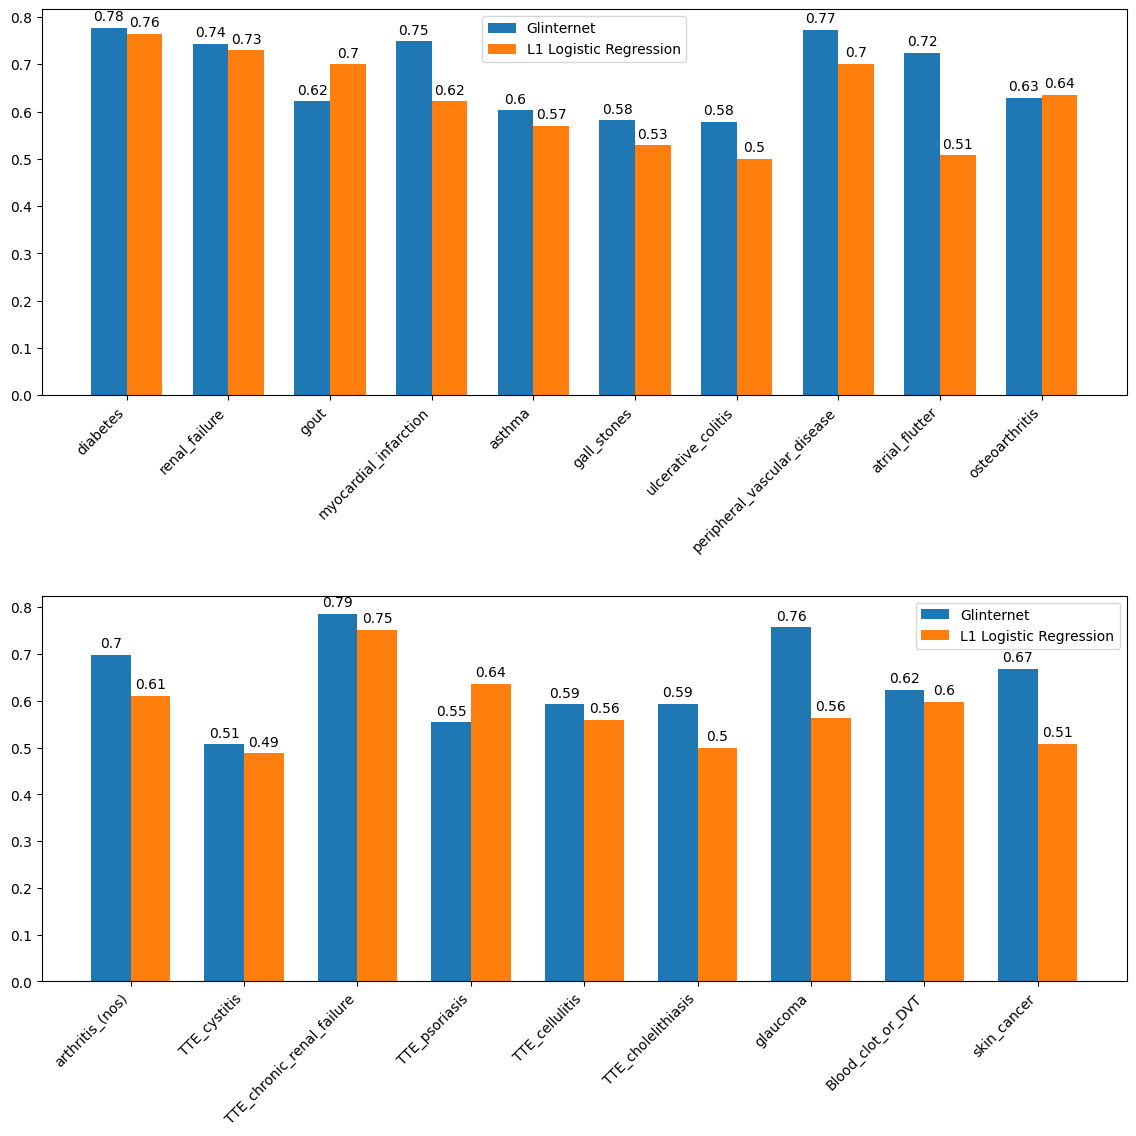

In [61]:
# Splitting the data for two subplots
first_half_diseases  = list(disease_codes.keys())[:10]
second_half_diseases = list(disease_codes.keys())[10:]

first_half_aucs1  = aucs_glinternet[:10]
second_half_aucs1 = aucs_glinternet[10:]

first_half_aucs2  = aucs_log_reg[:10]
second_half_aucs2 = aucs_log_reg[10:]

# Function to create a bar plot for a given set of data
def create_subplot(ax, disease_names, aucs1, aucs2, width=0.35):
    x = list(range(len(disease_names)))
    rects1 = ax.bar([xi - width/2 for xi in x], aucs1, width, label='Glinternet')
    rects2 = ax.bar([xi + width/2 for xi in x], aucs2, width, label='L1 Logistic Regression')
    ax.set_xticks(x)
    ax.set_xticklabels(disease_names, rotation=45, ha='right')
    ax.legend()

    # Add values on top of the bars
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Creating the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # Adjust figure size as needed

create_subplot(ax1, first_half_diseases, first_half_aucs1, first_half_aucs2)
create_subplot(ax2, second_half_diseases, second_half_aucs1, second_half_aucs2)

fig.tight_layout(pad=3.0)
plt.show()

In [59]:
sum(aucs_glinternet) / len(aucs_glinternet)

0.6612821498371709

In [60]:
sum(aucs_log_reg) / len(aucs_log_reg)

0.6039918556811198